# Demo 2: Multiple slit interference 
This notebook runs on Oqtant hardware and uses **4 jobs** 

## Introduction ##

This notebook has been adapted from the works of [Dr. Carrie Weidner](https://www.bristol.ac.uk/qet-labs/research/weidner-group/), many thanks for her efforts and collaboration!

In this demo, we show how the Oqtant Quantum Matter Service can be used to observe interference between many Bose-Einstein condensates (BECs)! The double slit experiment is one of the most famous physics experiments, and is taught in introductory quantum mechanics classes. If you are unfamiliar with this experiment - you can read about it [here](https://plus.maths.org/content/physics-minute-double-slit-experiment-0). The original double slit experiment demonstrates the wave-particle duality of matter. 

This demo is very similar to the double slit experiment, but uses many slits instead of just two. We form many slits by creating an array of optical potential barriers, also known as a diffraction grating. The barrier array is gently ramped on in time to form many different spatially separated BECs. After releasing these BECs from the trap, the BECs "diffract" and interfere with one another as they expand during [time-of-flight](https://oqtant.infleqtion.com/technical/imaging.md) (TOF). The diffraction patterns which form are a demonstration of the wavelike nature of the Bose-Einstein condensates created with Oqtant's Quantum Matter Service.

If you're interested in learning more, you can check out the following paper: [Interference of an array of independent Bose-Einstein condensates](https://arxiv.org/abs/quant-ph/0405113). This paper uses a very similar experiment to study what happens when the "phases" of the neighboring BECs are correlated versus when the phases are entirely random. 

### Imports and user authentication ###

In [ ]:
from oqtant.schemas.quantum_matter import QuantumMatterFactory
import numpy as np
import matplotlib.pyplot as plt

qmf = QuantumMatterFactory()
qmf.get_login()

In [2]:
qmf.get_client()

Job Limits:
╒══════════════╤═══════════════════╤═══════════════╤═══════════════════════╕
│   Daily Used │   Daily Remaining │   Daily Limit │   Purchased Remaining │
╞══════════════╪═══════════════════╪═══════════════╪═══════════════════════╡
│            0 │                10 │            10 │                    10 │
╘══════════════╧═══════════════════╧═══════════════╧═══════════════════════╛


## Construct a periodic optical potential

Create the periodic optical/ diffraction grating that we will apply to the condensate during the experiment. Using snapshots to build a dynamic landscape, we can create multiple barriers in a single object with a given height and spacing.

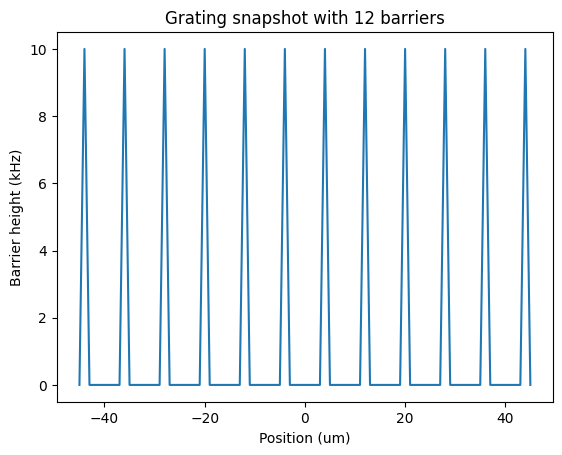

In [3]:
n_barriers = 12  # number of barrier peaks
potential_height = 10  # height of the barrier potentials (kHz)
landscape_width = 90  # the total landscape size we're projecting over (um)
T = 50  # target temperature of the atoms (nK)

positions = np.arange(
    -(landscape_width / 2), (landscape_width / 2) + 1, 1
)  # setting up the spatial array of points centered around the grid size above
barrier_positions = np.linspace(
    -(landscape_width / 2) + 1, (landscape_width / 2) - 1, n_barriers
)
periodic_potential = potential_height * np.in1d(positions, np.round(barrier_positions))

plt.figure()
plt.plot(positions, periodic_potential)
plt.xlabel("Position (um)")
plt.ylabel("Barrier height (kHz)")
plt.title("Grating snapshot with " + str(n_barriers) + " barriers")
plt.show()

## Create static snapshots ##

By combining multiple snapshots, we can add time dynamics to the landscape to change the grating potential over time. Here we will visualize the two snapshot potentials. Note that we have used the default timesteps and interpolation methods to control how the landscape changes from one snapshot to another.

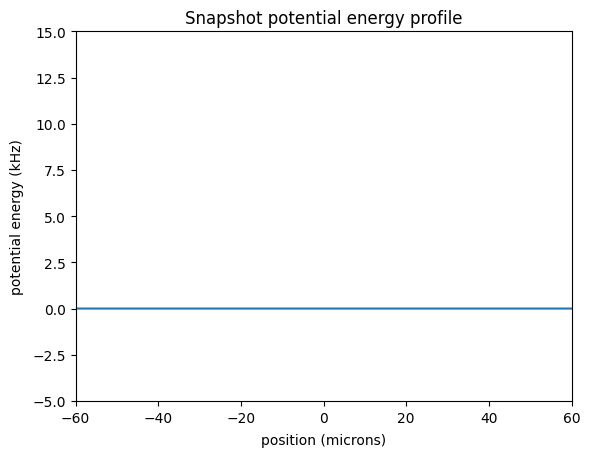

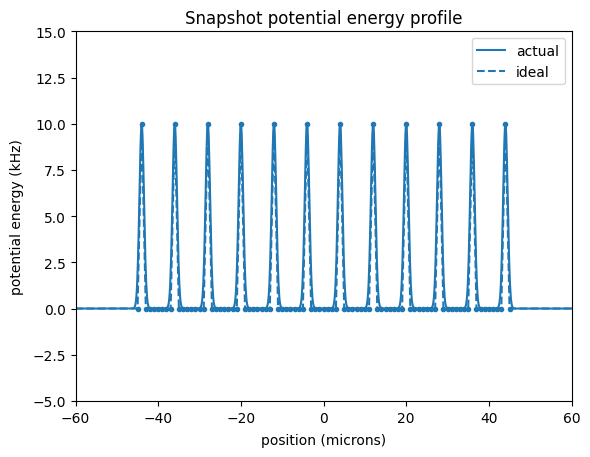

In [4]:
time_evolve = 2  # end time for periodic snapshot

snapshot_zero = qmf.create_snapshot(
    time=0,
    positions=positions,
    potentials=np.zeros_like(positions),
    interpolation="OFF",
)

snapshot_periodic = qmf.create_snapshot(
    time=time_evolve,
    positions=positions,
    potentials=periodic_potential,
    interpolation="LINEAR",
)

snapshot_zero.show_potential(xlimits=[-60, 60], ylimits=[-5, 15])
snapshot_periodic.show_potential(
    xlimits=[-60, 60], ylimits=[-5, 15], include_ideal=True
)

## Create a landscape from snapshots ##

Now we need to add the two snapshots to our Quantum Matter landscape. By doing this, the quantum matter factory will linearly interpolate points between the snapshots to make a gentle transition between different snapshots.

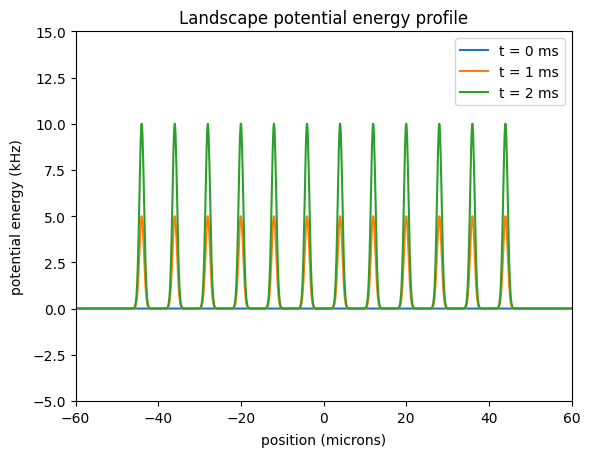

In [5]:
landscape_periodic = qmf.create_landscape(snapshots=[snapshot_zero, snapshot_periodic])

landscape_periodic.show_potential(times=[0, 1, 2], xlimits=[-60, 60], ylimits=[-5, 15])

## Create a list of jobs with different times of flight ##

Now we're ready to submit our experiment to the hardware and realize the results. In this section we must first choose at which times of flight (TOFs) we want to observe the condensate. The number of TOFs that are listed will be the number of jobs submitted. Here, we are submitting the jobs as a list, however it's also possible to submit as a batch which ensures that the jobs all run sequentially (uninterrupted by other users jobs) as demonstrated in [walkthrough #5](https://oqtant-docs.infleqtion.com/examples/walkthroughs/walkthrough_5_experimentation_and_batch_jobs/).

In [6]:
tofs = [5, 10, 15, 20]
matters_tof = []

for tof in tofs:
    matters_tof.append(
        qmf.create_quantum_matter(
            temperature=T,
            lifetime=time_evolve,
            landscape=landscape_periodic,
            time_of_flight=tof,
            name="Many BEC interference, tof = " + str(tof) + " ms",
        )
    )

With the landscape potential now added to the overall magnetic potential, we can visualize the complete energy profile.

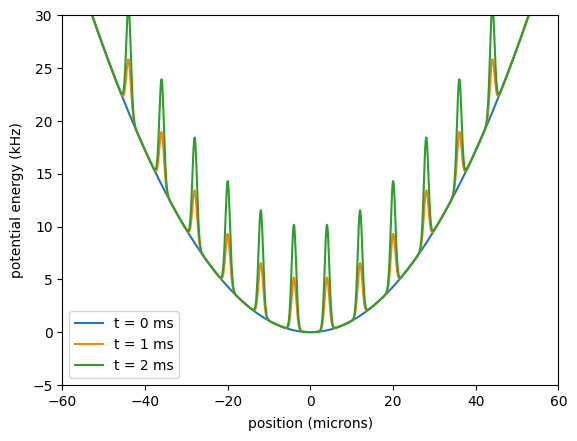

In [7]:
matters_tof[0].show_potential(times=[0, 1, 2], xlimits=[-60, 60], ylimits=[-5, 30])

## Submit the jobs to the Quantum Matter Service  ##

In [8]:
[matter.submit(track=True) for matter in matters_tof]
id_list = [matter.job_id for matter in matters_tof]

Submitting 1 job(s):

- Job: Many BEC interference, tof = 5 ms
  Job ID: 5cfe6e41-8811-46b3-ab4b-b70fbc01646d

Tracking 1 job(s):

- Job: Many BEC interference, tof = 5 ms
  - RUNNING
  - COMPLETE

All job(s) complete
Submitting 1 job(s):

- Job: Many BEC interference, tof = 10 ms
  Job ID: 193ba884-1c36-45f9-bb1b-7c29af68f7b5

Tracking 1 job(s):

- Job: Many BEC interference, tof = 10 ms
  - RUNNING
  - COMPLETE

All job(s) complete
Submitting 1 job(s):

- Job: Many BEC interference, tof = 15 ms
  Job ID: 41468163-06ff-4188-9c2f-630ff59ff15c

Tracking 1 job(s):

- Job: Many BEC interference, tof = 15 ms
  - RUNNING
  - COMPLETE

All job(s) complete
Submitting 1 job(s):

- Job: Many BEC interference, tof = 20 ms
  Job ID: a9858a8f-ced3-4a75-ac83-53d87d289d43

Tracking 1 job(s):

- Job: Many BEC interference, tof = 20 ms
  - RUNNING
  - COMPLETE

All job(s) complete


## Retrieve and plot results ##

First let's take a look at the TOF images returned below:

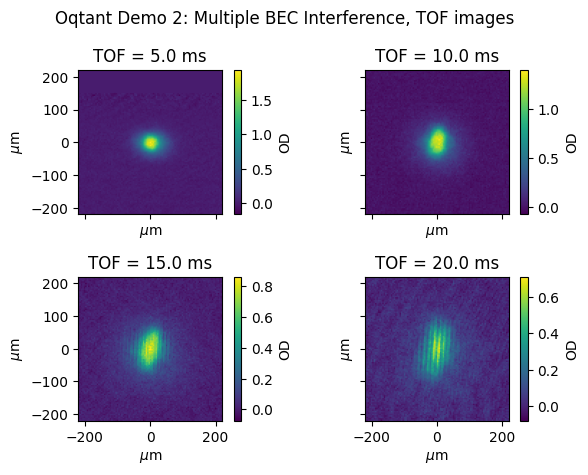

In [9]:
for matter in matters_tof:
    matter.get_result()

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
ax_flat = axes.flatten()

for i in range(len(matters_tof)):
    pixcal = matters_tof[i].output.get_image_pixcal(image="TIME_OF_FLIGHT")
    tof_image = matters_tof[i].output.get_image_data(image="TIME_OF_FLIGHT")
    ax = ax_flat[i]
    im = ax.imshow(
        tof_image, extent=[-50 * pixcal, 50 * pixcal, -50 * pixcal, 50 * pixcal]
    )
    ax.set_title("TOF = " + str(matters_tof[i].time_of_flight) + " ms")
    ax.set_xlabel("$\mu$m")
    ax.set_ylabel("$\mu$m")
    fig.colorbar(im, ax=ax, label="OD")

fig.suptitle("Oqtant Demo 2: Multiple BEC Interference, TOF images")
fig.tight_layout()
plt.show()

Another useful way to analyze at the images is to look at the centers of their slices:

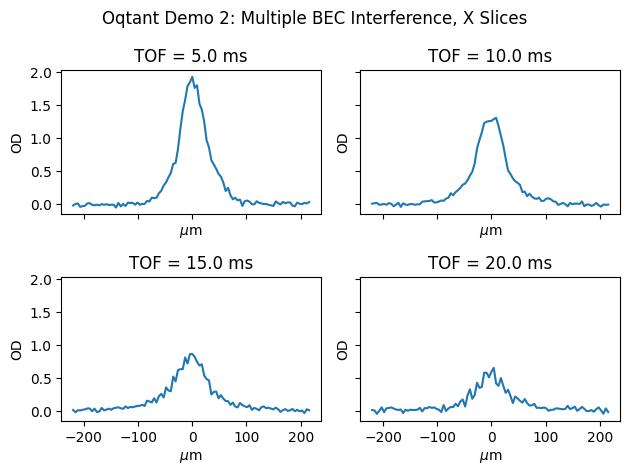

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
ax_flat = axes.flatten()

for i in range(len(matters_tof)):
    ax_flat[i].plot(
        np.arange(-50, 50) * pixcal, np.array(matters_tof[i].output.get_slice(axis="x"))
    )
    ax_flat[i].set_title("TOF = " + str(matters_tof[i].time_of_flight) + " ms")
    ax_flat[i].set_ylabel("OD")
    ax_flat[i].set_xlabel("$\mu$m")

fig.suptitle("Oqtant Demo 2: Multiple BEC Interference, X Slices")
fig.tight_layout()
plt.show()

Look how cool this is! (pun intended) These exciting images are a demonstration of the wave-like nature of the Bose Einstein Condensates created with Oqtant's Quantum Matter Service. You'll notice that the diffraction pattern isn't observable for all times of flight, but as the cloud expands, the interference between the clouds becomes observable. 

It's important to note that there are some hardware limitations that you may run into when exploring this effect further, namely the camera resolution and time of flight restrictions. Atom-atom interactions also complicate the matter. These will all have an impact on the experimental results returned. One great way to further explore this effect is by using our quantum matter simulator!